# PyTorch101 - Part 5 - Remote GPU Training
In this part of the tutorial, we will discover how to train on GPUs while also understanding how to train remotely and saving a model, to make inference offline afterwards.

We decided not to use a remote jupyter notebook just replicated as before; instead, we decided to create an end-to-end training script which is launched directly on the remote machine. This script includes the data loading and the tensorboard logging as before.

This notebook is mostly intended as a presentation for new instructions, namely the GPU execution and the model saving/loading, but also as a presentation of the results, both in terms of accuracy of the local inference and on time requirements.

In [53]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
print(torch.__version__)
print(torchvision.__version__)

0.4.0
0.2.1


## GPU Training: what we need to do
To effectively use a GPU for computation, we need to move everything (model, parameters and data) to the GPU device. In PyTorch, each tensor resides in a specific device: this is quite different from tensorflow, where it simply uses GPU when it can and it does not provide any manual control on where data resides.

To move tensors to GPU it suffice to call the *.to(device)* instruction, where device can be both a CPU or a GPU when available

In [ ]:
# Find the available device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Move network to device
net.to(device)

## Saving a Model
The procedure to save a model depends on wether we want to continue training o just use the local copy for inference. Basically, if we want to continue training, we also need to save the current epoch and the optimizer state. When we use the model for inference, we call the *.eval()* method

### Model used for inference

In [ ]:
# Save the model to a file
torch.save(model.state_dict(), filepath)

# Load the model for inference
model.load_state_dict(torch.load(filepath))
model.eval()

### Continue training

In [ ]:
# Create a cumulative state
state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    # Can also include scores and other
}
# Save 
torch.save(state, filepath)

# Loading to continue training
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(stata['optimizer'])

## Experimental Results
Running the same model on GPU requires little effort to adapt the code, while improving speed a lot. In this simple case, the speed-up running on GPU was just 4x (2 minutes instead of 8 minutes).
The testing machine was equipped with 4 vCPU and a k80 GPU (Google Compute Engine). 
The plot from tensorboard is shown below, same as before.

The accuracy on the test set is quite similar, also because the architecture was the same and the training was similar.

![Tensorboard output](img/mnist-remote.png)

## CIFAR
As an extensive experiment, we want to try the same script, with little modification to the network architecture obviously, on the CIFAR dataset, to see how it performs. 

The CIFAR10 dataset, which can be downloaded using the torchvision helpers as the MNIST, contains a total of 50k images for training and 10k images for testing. Each of these images has 32x32 pixels and 3 channels (standard RGB). The images are already in the format [0,1] (instead of [0,255]).

We will try the previous architecture, to see how it compares (our baseline), but also a VGG-like architecture, with a total of 11 layers, modified for the CIFAR10 dataset.

Here we provide a review of the experiments, in tabular form, of the accuracy and the relative hyperparameters. We use the "baseline" alias for the MNIST equivalent architecture, while we use the "VGG" alias for the VGG-like architecture.

| Arch        | Epochs | Accuracy   |
|------       |------  |-------     |
|   Baseline  | 2      | 0.5078     |
|   Baseline  | 4      | 0.6096     |
|   Vgg       | 16     | 0.7903     |

## Visualization
We can also try to visualize the results, showing 4 images and their relative categories.

In [89]:
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.CIFAR10(root='./cifar/cifar_data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

Files already downloaded and verified


In [90]:
dataiter = iter(testloader)
images, labels = dataiter.next()

def show_results(net):
    outputs = net(images)
    o = outputs.detach().numpy()
    predictions = np.argmax(o, axis=1)

    print("True labels:", [classes[i] for i in labels])
    print("Predicted labels:", [classes[i] for i in predictions])
    f, ax = plt.subplots(1, 8, figsize=(16,4))
    _images = np.transpose(images, [0, 2, 3, 1])
    for i in range(_images.shape[0]):
        ax[i].imshow(_images[i])
        ax[i].set_axis_off()
    plt.show()

## Baseline

True labels: ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog']
Predicted labels: ['cat', 'automobile', 'ship', 'airplane', 'deer', 'frog', 'automobile', 'frog']


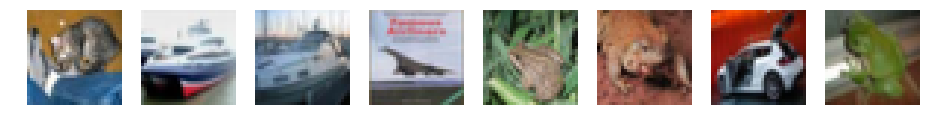

In [91]:
from cifar.archs import BaselineNet
net = BaselineNet()
net.load_state_dict(torch.load('cifar/model/baseline4e.torch', map_location='cpu'))
net.eval()
show_results(net)

## Comments
The following screenshot shows the training of the different architectures. I tried 3 different setups for the VGG architecture:
- VGG with 11 layers
- VGG-mini with 6 layers
- VGG11 with Batch Norm in each layer

The screenshot shows why you should *clearly* use Batch Norm with deep neural networks. 

Obviously the results on the test set show how this network does not generalize well, which can be explained by a series of factors: 
- Model is probably overfitting because of the high number of epochs
- Model did not use dropout
- Model is not tuned, this is just the first result we got

![Tensorboard output](img/vgg.png)